In [2]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
nlp = spacy.load('en_core_web_sm')

with open('brennu-njals_saga_en.txt', 'r') as file:
    text = file.read()

In [4]:
doc = nlp(text)

['King Brian', 150951, 'King Brian', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 150951, 'King Kylfi', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 150951, 'King Brian', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 151000, 'Kerthialfad', 151005, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 150951, 'King Kylfi', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 150951, 'King Brian', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 151000, 'Kerthialfad', 151005, 'son', 'attr', [['son', 150949, 'attr']]]
['King Kylfi', 150951, 'King Brian', 150951, 'son', 'attr', [['son', 150949, 'attr']]]
['King Kylfi', 151000, 'Kerthialfad', 151005, 'son', 'attr', [['son', 150949, 'attr']]]
['King Brian', 151000, 'Kerthialfad', 151005, 'son', 'attr', [['son', 150949, 'attr']]]
['Duncan', 151037, "King Brian's", 151045, 'sons', 'nsubj', [['sons', 151075, 'nsubj'], ['briskest', 151085, 'conj']]]
['Dunca

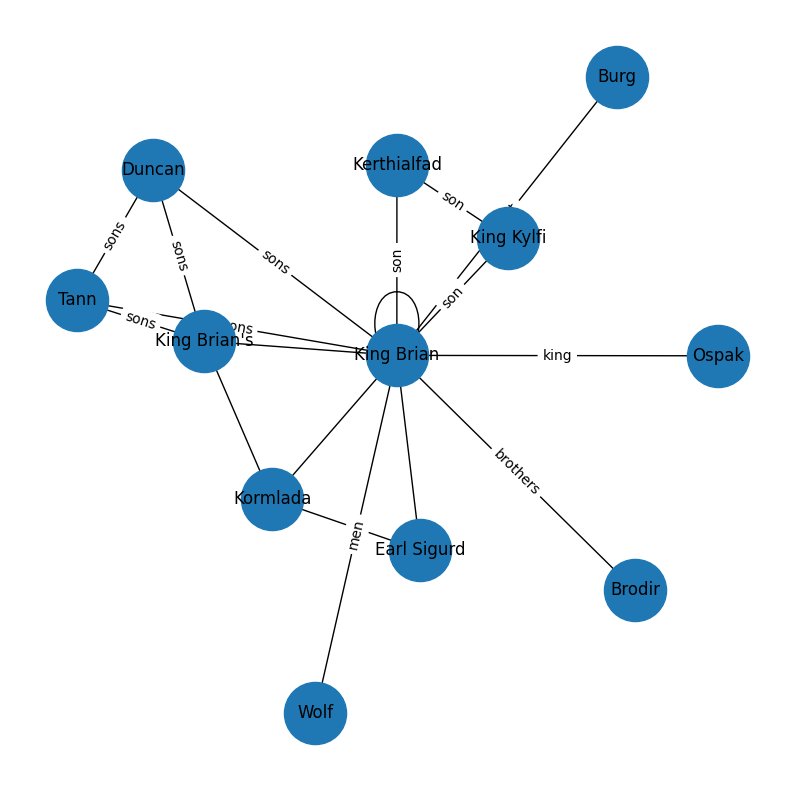

In [53]:
graph = nx.Graph()

# Define the name of the person to filter
person_name = "King Brian"  # Replace with the desired person's name

# Iterate over the named entities and add them as nodes to the graph
for entity in doc.ents:
    if entity.label_ == 'PERSON':
        graph.add_node(entity.text)

ls_all=[]
# Iterate over the sentences and extract the connections between characters
for sent in doc.sents:
    sent_ents = [ent.text for ent in sent.ents if ent.label_ == 'PERSON']
    if person_name in sent_ents:
        for i in range(len(sent_ents)):
            for j in range(i + 1, len(sent_ents)):
                node1 = sent_ents[i]
                node2 = sent_ents[j]
                
                node1_token = None
                node2_token = None

                # Find the tokens corresponding to node1 and node2
                for token in sent:
                    if token.text == node1.split()[0]:
                        node1_token = token
                    if token.text == node2.split()[0]:
                        node2_token = token
                    if node1_token and node2_token:
                        break
                
                if graph.has_edge(node1, node2):
                    # Increment the weight of the edge if it already exists
                    graph[node1][node2]['weight'] += 1
                else:
                    # Add a new edge with weight 1 if it doesn't exist
                    graph.add_edge(node1, node2, weight=1)

                # Extract the relationship between the characters from the sentence
                relationship = ''
                dependancy = ''
                token_s=[]

                for token in sent:
                    if  ((token.dep_ == 'attr'and token.text == 'son') or
                         (token.dep_ == 'nsubj'and token.pos_ == 'NOUN') or
                         (token.dep_ == 'poss'and token.pos_ == 'NOUN') or
                         (token.dep_ == 'conj'and token.pos_ == 'NOUN') or
                         (token.dep_ == 'appos'and token.pos_ == 'NOUN')):
                        #relationship = token.text
                        token_s.append([token.text,token.i,token.dep_])
                
                dif = 100
                for k in token_s:
                    if (k[1] > node1_token.i) & (k[1] < node2_token.i):
                        difference = abs(node1_token.i - k[1])
                        if difference < dif:
                            relationship = k[0]
                            dependancy = k[2]
                            #print("CHECK1: ",node1,node2,k[0],relationship,difference, dif)
                            dif = difference
                
                dif = 100
                if relationship == "":
                    for k in token_s:
                        difference = abs(node1_token.i - k[1])
                        if difference < dif:
                            relationship = k[0]
                            dependancy = k[2]
                            #print("CHECK2: ",node1,node2,k[0],relationship,difference, dif)
                            dif = difference               

                # Assign the relationship name as an edge attribute
                graph[node1][node2]['relationship'] = relationship
                ls_all.append([node1,node1_token.i,node2,node2_token.i,relationship,dependancy,token_s])

# Filter the graph to include only nodes and edges related to the specified person
subgraph = graph.subgraph(nx.node_connected_component(graph, person_name))

# Draw the filtered graph
pos = nx.spring_layout(subgraph, seed=42)
edge_labels = nx.get_edge_attributes(subgraph, 'relationship')
plt.figure(figsize=(10, 10))
nx.draw_networkx(subgraph, pos, with_labels=True, node_size=2000, font_size=12)
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=10)
plt.axis('off')
#plt.show()
plt.savefig(f'graphs/{person_name}.png')
for i in ls_all:
    print(i)

In [24]:
G = nx.Graph()

# Iterate over the named entities and add them as nodes to the graph
for entity in doc.ents:
    if entity.label_ == 'PERSON':
        G.add_node(entity.text)
ls_all=[]
# Iterate over the sentences and extract the connections between characters
for sent in doc.sents:
    sent_ents = [ent.text for ent in sent.ents if ent.label_ == 'PERSON']
    for i in range(len(sent_ents)):
        for j in range(i + 1, len(sent_ents)):
            node1 = sent_ents[i]
            node2 = sent_ents[j]
            node1_token = None
            node2_token = None

            # Find the tokens corresponding to node1 and node2
            for token in sent:
                if token.text == node1.split()[0]:
                    node1_token = token
                if token.text == node2.split()[0]:
                    node2_token = token
                if node1_token and node2_token:
                    break
            
            if G.has_edge(node1, node2):
                # Increment the weight of the edge if it already exists
                G[node1][node2]['weight'] += 1
            else:
                # Add a new edge with weight 1 if it doesn't exist
                G.add_edge(node1, node2, weight=1)

            # Extract the relationship between the characters from the sentence
            relationship = ''
            token_s=[]

            for token in sent:
                if  ((token.dep_ == 'attr'and token.text == 'son') or
                        (token.dep_ == 'nsubj'and token.pos_ == 'NOUN') or
                        (token.dep_ == 'poss'and token.pos_ == 'NOUN') or
                        (token.dep_ == 'conj'and token.pos_ == 'NOUN') or
                        (token.dep_ == 'appos'and token.pos_ == 'NOUN')):
                    #relationship = token.text
                    token_s.append([token.text,token.i])
            
            dif = 100
            if (node1_token != None) & (node2_token != None):
                for k in token_s:
                    if (k[1] > node1_token.i) & (k[1] < node2_token.i):
                        difference = abs(node1_token.i - k[1])
                        if difference < dif:
                            relationship = k[0]
                            #print("CHECK1: ",node1,node2,k[0],relationship,difference, dif)
                            dif = difference
                
                dif = 100
                if relationship == "":
                    for k in token_s:
                        difference = abs(node1_token.i - k[1])
                        if difference < dif:
                            relationship = k[0]
                            #print("CHECK2: ",node1,node2,k[0],relationship,difference, dif)
                            dif = difference

            # Assign the relationship name as an edge attribute
            G[node1][node2]['relationship'] = relationship

In [26]:
degree = dict(G.degree())

sorted_nodes = sorted(degree, key=degree.get, reverse=True)

N = 10  # Number of nodes to retrieve

# Get the N highest nodes with the most neighboring nodes
highest_nodes = sorted_nodes[:N]

print("Nodes with the most neighboring nodes:")
for node in highest_nodes:
    print(f"Node {node}: Degree = {degree[node]}")

Nodes with the most neighboring nodes:
Node Kari: Degree = 70
Node Gunnar: Degree = 62
Node Skarphedinn: Degree = 44
Node Earl: Degree = 42
Node Thou: Degree = 40
Node Njal: Degree = 32
Node Kolbein: Degree = 27
Node Sigfus: Degree = 26
Node Gunnar Lambi's: Degree = 26
Node Thorstein: Degree = 24


In [55]:
# Calculate the number of edges connecting neighboring nodes and their contents
edge_count = {}
edge_contents = {}
for node in G.nodes():
    neighbors = G.neighbors(node)
    count = 0
    contents = []
    for neighbor in neighbors:
        edge_data = G.get_edge_data(node, neighbor)
        if edge_data:
            count += 1
            contents.append(edge_data['relationship'])
    edge_count[node] = count
    edge_contents[node] = contents

# Sort the nodes based on the number of edges in descending order
sorted_nodes = sorted(edge_count, key=edge_count.get, reverse=True)

N = 50  # Number of nodes to retrieve

# Get the N highest nodes with the most edges connecting neighboring nodes
highest_nodes = sorted_nodes[:N]

print("Nodes with the most edges connecting neighboring nodes:")
for node in highest_nodes:
    print(f"Node {node}: Edge Count = {edge_count[node]}")
    print("Edge Contents:", edge_contents[node])
    print()


Nodes with the most edges connecting neighboring nodes:
Node Kari: Edge Count = 69
Edge Contents: ['', 'sword', 'end', 'man', '', 'man', 'slaying', 'trial', '', '', '', '', 'thou', 'sons', 'daring', '', 'end', 'east', '', '', 'son', 'father', 'son', 'ye', '', 'children', '', 'purpose', 'men', '', 'son', 'part', 'shalt', 'son', '', 'bargain', 'bargain', 'chiefs', 'son', 'bone', 'bone', '', '', 'son', '', 'son', 'son', '', '', 'atonement', 'son', 'son', 'men', '', '', 'housewife', 'son', 'sword', 'sword', 'others', 'son', 'Chapter', 'son', 'blow', '', 'son', 'black', 'black', 'priest']

Node Gunnar: Edge Count = 61
Edge Contents: ['', 'Arnguda', '', '', 'men', '', '', 'man', '', 'shepherd', 'swords', 'eye', '', 'son', 'spring', 'ship', 'priest', 'man', 'sons', 'sons', 'end', 'wife', 'son', 'matter', '', 'shalt', 'thou', 'slaying', '', 'doest', 'son', '', 'priest', '', '', 'shalt', 'canst', '', '', 'attack', 'thing', '', 'son', 'hand', '', 'kinsman', 'sword', '', 'messmate', 'outlaws', 's